### 라이브러리 불러오기

In [593]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%config InlineBackend.figure_format = 'retina'  #선명하게 만들기

from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, MaxAbsScaler, RobustScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score,mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression

In [594]:
# 결측치 확인하는 라이브러리
import missingno as msno 

# 다중대체 라이브러리
from fancyimpute import IterativeImputer

# Warning 메세지를 뜨지 않게 해줌
import warnings
warnings.filterwarnings('ignore')

In [595]:
# Window의 한글 폰트 설정
plt.rc('font', family='Malgun Gothic')
plt.rc('axes', unicode_minus=False)

### 데이터 불러오기
train & test dataset 불러오기

In [596]:
# working directory 확인
os.getcwd() #현재 작업 위치 출력

'c:\\Users\\chica\\OneDrive\\바탕 화면\\Workspace\\BAF-15-Fresh-Edu\\4주차 과제_모델링2'

In [597]:
# train dataset 불러오기
train = pd.read_csv('../과제 데이터/train_new.csv')
train = train.copy()

In [598]:
train.isna().sum()

Date                         0
Rented Bike Count            0
Hour                         0
Temperature(°C)              0
Humidity(%)                  0
Wind speed (m/s)             0
Visibility (10m)             0
Dew point temperature(°C)    0
Solar Radiation (MJ/m2)      0
Rainfall(mm)                 0
Snowfall (cm)                0
Seasons                      0
Holiday                      0
Functioning Day              0
month                        0
dtype: int64

In [599]:
# test dataset 불러오기
test = pd.read_csv('../과제 데이터/test.csv', encoding='cp949')
test_copy = test.copy()

In [600]:
test_copy.isna().sum()

Date                           0
Hour                           0
Temperature(°C)              174
Humidity(%)                    0
Wind speed (m/s)             171
Visibility (10m)               0
Dew point temperature(°C)      0
Solar Radiation (MJ/m2)        0
Rainfall(mm)                   0
Snowfall (cm)                  0
Seasons                      177
Holiday                        0
Functioning Day                0
dtype: int64

In [601]:
# 계절 결측치

test_copy['month'] = pd.to_datetime(test_copy['Date'], format='%d/%m/%Y')
test_copy['month'] = test_copy['month'].dt.month

season_mapping = {
    12: 'Winter', 1: 'Winter', 2: 'Winter',
    3: 'Spring', 4: 'Spring', 5: 'Spring',
    6: 'Summer', 7: 'Summer', 8: 'Summer',
    9: 'Autumn', 10: 'Autumn', 11: 'Autumn'
}

test_copy['Seasons'] = test_copy.apply(lambda row: season_mapping.get(row['month'], np.nan) if pd.isna(row['Seasons']) else row['Seasons'], axis=1)

test_copy.isna().sum()

Date                           0
Hour                           0
Temperature(°C)              174
Humidity(%)                    0
Wind speed (m/s)             171
Visibility (10m)               0
Dew point temperature(°C)      0
Solar Radiation (MJ/m2)        0
Rainfall(mm)                   0
Snowfall (cm)                  0
Seasons                        0
Holiday                        0
Functioning Day                0
month                          0
dtype: int64

In [602]:
# 온도 결측치

def fill_nan_temperature(row, stats_by_season_hour):
    if pd.isna(row['Temperature(°C)']):
        season = row['Seasons']
        hour = row['Hour']
        mean_temperature = stats_by_season_hour.loc[(season, hour), 'mean']
        std_deviation = stats_by_season_hour.loc[(season, hour), 'std']
        return np.random.normal(loc=mean_temperature, scale=std_deviation)
    else:
        return row['Temperature(°C)']

def fill_nan_temperatures(dataframe):
    # 계절과 시간대별 평균 및 표준편차 계산
    stats_by_season_hour = dataframe.groupby(['Seasons', 'Hour'])['Temperature(°C)'].agg(['mean', 'std'])
    
    # apply 메서드를 사용하여 결측값 채우기
    dataframe['Temperature(°C)'] = dataframe.apply(lambda row: fill_nan_temperature(row, stats_by_season_hour), axis=1)

# 데이터프레임에 결측값 채우기
fill_nan_temperatures(test_copy)

test_copy.isna().sum()

Date                           0
Hour                           0
Temperature(°C)                0
Humidity(%)                    0
Wind speed (m/s)             171
Visibility (10m)               0
Dew point temperature(°C)      0
Solar Radiation (MJ/m2)        0
Rainfall(mm)                   0
Snowfall (cm)                  0
Seasons                        0
Holiday                        0
Functioning Day                0
month                          0
dtype: int64

In [603]:
# 풍속 결측치

from sklearn.impute import KNNImputer

df_numeric = test.select_dtypes(include=['float64', 'int64'])

# 결측치를 채우기 위한 특정 변수 선택
feature = ['Wind speed (m/s)']
X = df_numeric[feature].values

# KNN 모델을 사용하여 결측치 채우기
knn_imputer = KNNImputer(n_neighbors=3)
X_imputed = knn_imputer.fit_transform(X)

# 결과를 데이터프레임으로 변환
df_numeric_imputed = pd.DataFrame(X_imputed, columns=feature)

# 원본 데이터프레임에 대체된 값 반영
test_copy[feature] = df_numeric_imputed

test_copy.isna().sum()

Date                         0
Hour                         0
Temperature(°C)              0
Humidity(%)                  0
Wind speed (m/s)             0
Visibility (10m)             0
Dew point temperature(°C)    0
Solar Radiation (MJ/m2)      0
Rainfall(mm)                 0
Snowfall (cm)                0
Seasons                      0
Holiday                      0
Functioning Day              0
month                        0
dtype: int64

In [604]:
# 데이터 구조 확인
print(train.shape)
display(train.head())
display(train.tail())
train.info()

(7008, 15)


,Date,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day,month
0,24/10/2018,1492,16,12.023117,42.0,1.3,1976,5.0,1.22,0.0,0.0,Autumn,No Holiday,Yes,10
1,01/05/2018,1536,14,23.000000,64.0,2.8,520,15.8,1.59,0.0,0.0,Spring,Holiday,Yes,5
2,14/11/2018,327,2,6.200000,59.0,0.6,1584,-1.2,0.00,0.0,0.0,Autumn,No Holiday,Yes,11
3,31/08/2018,170,4,23.200000,83.0,1.6,1102,20.1,0.00,0.0,0.0,Summer,No Holiday,Yes,8
4,26/06/2018,45,5,23.700000,64.0,0.9,876,16.4,0.00,0.1,0.0,Summer,No Holiday,Yes,6


,Date,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day,month
7003,08/02/2018,255,7,-9.6,67.0,1.0,1503,-14.5,0.00,0.0,0.0,Winter,No Holiday,Yes,2
7004,28/03/2018,104,4,10.6,77.0,0.9,422,6.7,0.00,0.0,0.0,Spring,No Holiday,Yes,3
7005,30/04/2018,569,0,14.7,54.0,1.3,718,5.4,0.00,0.0,0.0,Spring,No Holiday,Yes,4
7006,29/05/2018,2234,8,20.5,66.0,1.7,1062,13.9,0.34,0.0,0.0,Spring,No Holiday,Yes,5
7007,20/09/2018,1290,17,19.3,76.0,2.1,2000,14.9,0.21,0.0,0.0,Autumn,No Holiday,Yes,9


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7008 entries, 0 to 7007
Data columns (total 15 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Date                       7008 non-null   object 
 1   Rented Bike Count          7008 non-null   int64  
 2   Hour                       7008 non-null   int64  
 3   Temperature(°C)            7008 non-null   float64
 4   Humidity(%)                7008 non-null   float64
 5   Wind speed (m/s)           7008 non-null   float64
 6   Visibility (10m)           7008 non-null   int64  
 7   Dew point temperature(°C)  7008 non-null   float64
 8   Solar Radiation (MJ/m2)    7008 non-null   float64
 9   Rainfall(mm)               7008 non-null   float64
 10  Snowfall (cm)              7008 non-null   float64
 11  Seasons                    7008 non-null   object 
 12  Holiday                    7008 non-null   object 
 13  Functioning Day            7008 non-null   objec

In [605]:
train.isna().sum()

Date                         0
Rented Bike Count            0
Hour                         0
Temperature(°C)              0
Humidity(%)                  0
Wind speed (m/s)             0
Visibility (10m)             0
Dew point temperature(°C)    0
Solar Radiation (MJ/m2)      0
Rainfall(mm)                 0
Snowfall (cm)                0
Seasons                      0
Holiday                      0
Functioning Day              0
month                        0
dtype: int64

In [606]:
# 데이터 구조 확인
print(test_copy.shape)
display(test_copy.head())
display(test_copy.tail())
test_copy.info()

(1752, 14)


,Date,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day,month
0,11/07/2018,22,27.1,79,1.200000,1578,23.1,0.00,0.0,0.0,Summer,No Holiday,Yes,7
1,28/11/2018,11,5.7,15,1.100000,1419,-19.0,0.98,0.0,0.0,Autumn,No Holiday,Yes,11
2,18/04/2018,15,19.0,21,3.300000,1716,-3.8,2.88,0.0,0.0,Spring,No Holiday,Yes,4
3,09/03/2018,14,8.0,42,1.704428,1690,-4.1,1.24,0.0,0.0,Spring,No Holiday,Yes,3
4,28/10/2018,16,12.2,65,1.900000,2000,5.8,0.52,0.0,0.0,Autumn,No Holiday,Yes,10


,Date,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day,month
1747,08/05/2018,7,15.3,60,2.000000,2000,7.5,0.35,0.0,0.0,Spring,No Holiday,Yes,5
1748,19/03/2018,17,8.5,59,2.700000,1927,0.9,0.16,0.0,0.0,Spring,No Holiday,Yes,3
1749,04/10/2018,20,21.3,53,1.800000,2000,11.3,0.00,0.0,0.0,Autumn,No Holiday,No,10
1750,08/10/2018,12,19.2,31,0.500000,1994,1.6,2.40,0.0,0.0,Autumn,No Holiday,Yes,10
1751,19/07/2018,15,33.7,41,1.704428,1924,18.6,3.04,0.0,0.0,Summer,No Holiday,Yes,7


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1752 entries, 0 to 1751
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Date                       1752 non-null   object 
 1   Hour                       1752 non-null   int64  
 2   Temperature(°C)            1752 non-null   float64
 3   Humidity(%)                1752 non-null   int64  
 4   Wind speed (m/s)           1752 non-null   float64
 5   Visibility (10m)           1752 non-null   int64  
 6   Dew point temperature(°C)  1752 non-null   float64
 7   Solar Radiation (MJ/m2)    1752 non-null   float64
 8   Rainfall(mm)               1752 non-null   float64
 9   Snowfall (cm)              1752 non-null   float64
 10  Seasons                    1752 non-null   object 
 11  Holiday                    1752 non-null   object 
 12  Functioning Day            1752 non-null   object 
 13  month                      1752 non-null   int32

In [607]:
test_copy.isna().sum()

Date                         0
Hour                         0
Temperature(°C)              0
Humidity(%)                  0
Wind speed (m/s)             0
Visibility (10m)             0
Dew point temperature(°C)    0
Solar Radiation (MJ/m2)      0
Rainfall(mm)                 0
Snowfall (cm)                0
Seasons                      0
Holiday                      0
Functioning Day              0
month                        0
dtype: int64

## 2차 전처리
- 범주형 데이터 수치화
- 변수 선택
- train, valid, test 셋 분리 
- 변수 스케일링

### 1. 범주형 데이터 수치화

In [608]:
for column in train.columns:
    dtype = train[column].dtype
    if pd.api.types.is_numeric_dtype(dtype):
        print(f'{column}: 수치형')
    elif pd.api.types.is_categorical_dtype(dtype):
        print(f'{column}: 범주형')
    elif pd.api.types.is_object_dtype(dtype):
        print(f'{column}: 명목형')
    else:
        print(f'{column}: etc')

Date: 명목형
Rented Bike Count: 수치형
Hour: 수치형
Temperature(°C): 수치형
Humidity(%): 수치형
Wind speed (m/s): 수치형
Visibility (10m): 수치형
Dew point temperature(°C): 수치형
Solar Radiation (MJ/m2): 수치형
Rainfall(mm): 수치형
Snowfall (cm): 수치형
Seasons: 명목형
Holiday: 명목형
Functioning Day: 명목형
month: 수치형


(1) 명목형 변수 : Seasons, Holiday, Functioning Day, Date

1-1. Date

year, month, day로 쪼갠다

In [609]:
train['Date'] = pd.to_datetime(train['Date'], format='%d/%m/%Y')
train["year"] = train["Date"].dt.year
train["month"] = train["Date"].dt.month
train["day"] = train["Date"].dt.day
train

,Date,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day,month,year,day
0,2018-10-24,1492,16,12.023117,42.0,1.3,1976,5.0,1.22,0.0,0.0,Autumn,No Holiday,Yes,10,2018,24
1,2018-05-01,1536,14,23.000000,64.0,2.8,520,15.8,1.59,0.0,0.0,Spring,Holiday,Yes,5,2018,1
2,2018-11-14,327,2,6.200000,59.0,0.6,1584,-1.2,0.00,0.0,0.0,Autumn,No Holiday,Yes,11,2018,14
3,2018-08-31,170,4,23.200000,83.0,1.6,1102,20.1,0.00,0.0,0.0,Summer,No Holiday,Yes,8,2018,31
4,2018-06-26,45,5,23.700000,64.0,0.9,876,16.4,0.00,0.1,0.0,Summer,No Holiday,Yes,6,2018,26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7003,2018-02-08,255,7,-9.600000,67.0,1.0,1503,-14.5,0.00,0.0,0.0,Winter,No Holiday,Yes,2,2018,8
7004,2018-03-28,104,4,10.600000,77.0,0.9,422,6.7,0.00,0.0,0.0,Spring,No Holiday,Yes,3,2018,28
7005,2018-04-30,569,0,14.700000,54.0,1.3,718,5.4,0.00,0.0,0.0,Spring,No Holiday,Yes,4,2018,30
7006,2018-05-29,2234,8,20.500000,66.0,1.7,1062,13.9,0.34,0.0,0.0,Spring,No Holiday,Yes,5,2018,29


1-2. Seasons, Holiday, Functioning Day

원핫인코딩 사용

In [610]:
# 객체 생성
ohe = OneHotEncoder(sparse_output=False)

#데이터프레임에 학습하고 변환
result_ohe = ohe.fit_transform(train[['Seasons','Holiday']])
result_ohe

array([[1., 0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 1.]])

In [611]:
ohe.categories_

[array(['Autumn', 'Spring', 'Summer', 'Winter'], dtype=object),
 array(['Holiday', 'No Holiday'], dtype=object)]

In [612]:
#result_ohe는 numpy.array이므로 데이터프레임으로 변환
df_ohe = pd.DataFrame(result_ohe, columns=ohe.get_feature_names_out(['Seasons','Holiday']))
df_ohe

,Seasons_Autumn,Seasons_Spring,Seasons_Summer,Seasons_Winter,Holiday_Holiday,Holiday_No Holiday
0,1.0,0.0,0.0,0.0,0.0,1.0
1,0.0,1.0,0.0,0.0,1.0,0.0
2,1.0,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,1.0,0.0,0.0,1.0
4,0.0,0.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...
7003,0.0,0.0,0.0,1.0,0.0,1.0
7004,0.0,1.0,0.0,0.0,0.0,1.0
7005,0.0,1.0,0.0,0.0,0.0,1.0
7006,0.0,1.0,0.0,0.0,0.0,1.0


In [613]:
# 원래의 train 데이터와 병합
train = pd.concat([train, df_ohe], axis=1)
train.head()

,Date,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),...,Functioning Day,month,year,day,Seasons_Autumn,Seasons_Spring,Seasons_Summer,Seasons_Winter,Holiday_Holiday,Holiday_No Holiday
0,2018-10-24,1492,16,12.023117,42.0,1.3,1976,5.0,1.22,0.0,...,Yes,10,2018,24,1.0,0.0,0.0,0.0,0.0,1.0
1,2018-05-01,1536,14,23.000000,64.0,2.8,520,15.8,1.59,0.0,...,Yes,5,2018,1,0.0,1.0,0.0,0.0,1.0,0.0
2,2018-11-14,327,2,6.200000,59.0,0.6,1584,-1.2,0.00,0.0,...,Yes,11,2018,14,1.0,0.0,0.0,0.0,0.0,1.0
3,2018-08-31,170,4,23.200000,83.0,1.6,1102,20.1,0.00,0.0,...,Yes,8,2018,31,0.0,0.0,1.0,0.0,0.0,1.0
4,2018-06-26,45,5,23.700000,64.0,0.9,876,16.4,0.00,0.1,...,Yes,6,2018,26,0.0,0.0,1.0,0.0,0.0,1.0


test dataset에 대해서도 동일하게 적용한다

In [614]:
test_copy['Date'] = pd.to_datetime(test_copy['Date'], format='%d/%m/%Y')
test_copy["year"] = test_copy["Date"].dt.year
test_copy["month"] = test_copy["Date"].dt.month
test_copy["day"] = test_copy["Date"].dt.day

In [615]:
# test 셋에 대해서도 동일하게 원핫인코딩 적용
result_ohe = ohe.fit_transform(test_copy[['Seasons','Holiday']])
result_ohe

array([[0., 0., 1., 0., 0., 1.],
       [1., 0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0., 1.],
       ...,
       [1., 0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0., 1.]])

In [616]:
ohe.categories_

[array(['Autumn', 'Spring', 'Summer', 'Winter'], dtype=object),
 array(['Holiday', 'No Holiday'], dtype=object)]

In [617]:
#result_ohe는 numpy.array이므로 데이터프레임으로 변환
df_ohe2 = pd.DataFrame(result_ohe, columns=ohe.get_feature_names_out(['Seasons','Holiday']))
df_ohe2

,Seasons_Autumn,Seasons_Spring,Seasons_Summer,Seasons_Winter,Holiday_Holiday,Holiday_No Holiday
0,0.0,0.0,1.0,0.0,0.0,1.0
1,1.0,0.0,0.0,0.0,0.0,1.0
2,0.0,1.0,0.0,0.0,0.0,1.0
3,0.0,1.0,0.0,0.0,0.0,1.0
4,1.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...
1747,0.0,1.0,0.0,0.0,0.0,1.0
1748,0.0,1.0,0.0,0.0,0.0,1.0
1749,1.0,0.0,0.0,0.0,0.0,1.0
1750,1.0,0.0,0.0,0.0,0.0,1.0


In [618]:
# 원래의 test 데이터와 병합
test = pd.concat([test_copy, df_ohe2], axis=1)
test.head()

,Date,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),...,Functioning Day,month,year,day,Seasons_Autumn,Seasons_Spring,Seasons_Summer,Seasons_Winter,Holiday_Holiday,Holiday_No Holiday
0,2018-07-11,22,27.1,79,1.200000,1578,23.1,0.00,0.0,0.0,...,Yes,7,2018,11,0.0,0.0,1.0,0.0,0.0,1.0
1,2018-11-28,11,5.7,15,1.100000,1419,-19.0,0.98,0.0,0.0,...,Yes,11,2018,28,1.0,0.0,0.0,0.0,0.0,1.0
2,2018-04-18,15,19.0,21,3.300000,1716,-3.8,2.88,0.0,0.0,...,Yes,4,2018,18,0.0,1.0,0.0,0.0,0.0,1.0
3,2018-03-09,14,8.0,42,1.704428,1690,-4.1,1.24,0.0,0.0,...,Yes,3,2018,9,0.0,1.0,0.0,0.0,0.0,1.0
4,2018-10-28,16,12.2,65,1.900000,2000,5.8,0.52,0.0,0.0,...,Yes,10,2018,28,1.0,0.0,0.0,0.0,0.0,1.0


In [619]:
print(train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7008 entries, 0 to 7007
Data columns (total 23 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Date                       7008 non-null   datetime64[ns]
 1   Rented Bike Count          7008 non-null   int64         
 2   Hour                       7008 non-null   int64         
 3   Temperature(°C)            7008 non-null   float64       
 4   Humidity(%)                7008 non-null   float64       
 5   Wind speed (m/s)           7008 non-null   float64       
 6   Visibility (10m)           7008 non-null   int64         
 7   Dew point temperature(°C)  7008 non-null   float64       
 8   Solar Radiation (MJ/m2)    7008 non-null   float64       
 9   Rainfall(mm)               7008 non-null   float64       
 10  Snowfall (cm)              7008 non-null   float64       
 11  Seasons                    7008 non-null   object        
 12  Holida

In [620]:
print(test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1752 entries, 0 to 1751
Data columns (total 22 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Date                       1752 non-null   datetime64[ns]
 1   Hour                       1752 non-null   int64         
 2   Temperature(°C)            1752 non-null   float64       
 3   Humidity(%)                1752 non-null   int64         
 4   Wind speed (m/s)           1752 non-null   float64       
 5   Visibility (10m)           1752 non-null   int64         
 6   Dew point temperature(°C)  1752 non-null   float64       
 7   Solar Radiation (MJ/m2)    1752 non-null   float64       
 8   Rainfall(mm)               1752 non-null   float64       
 9   Snowfall (cm)              1752 non-null   float64       
 10  Seasons                    1752 non-null   object        
 11  Holiday                    1752 non-null   object        
 12  Functi

### 2. 변수 선택

In [623]:
# 필요없는 열 제거
train = train.drop(['Date','Seasons','Holiday', 'Functioning Day'], axis=1)
test = test.drop(['Date','Seasons','Holiday', 'Functioning Day'], axis=1)

In [624]:
print(train.info())
print(test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7008 entries, 0 to 7007
Data columns (total 19 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Rented Bike Count          7008 non-null   int64  
 1   Hour                       7008 non-null   int64  
 2   Temperature(°C)            7008 non-null   float64
 3   Humidity(%)                7008 non-null   float64
 4   Wind speed (m/s)           7008 non-null   float64
 5   Visibility (10m)           7008 non-null   int64  
 6   Dew point temperature(°C)  7008 non-null   float64
 7   Solar Radiation (MJ/m2)    7008 non-null   float64
 8   Rainfall(mm)               7008 non-null   float64
 9   Snowfall (cm)              7008 non-null   float64
 10  month                      7008 non-null   int32  
 11  year                       7008 non-null   int32  
 12  day                        7008 non-null   int32  
 13  Seasons_Autumn             7008 non-null   float

### 3. train, valid, test 셋 분리
test 파일이 따로 있으므로 split을 한 번만 해주면 됨

In [625]:
# X(독립변수), y(종속변수) 분리
X = train.drop('Rented Bike Count', axis=1)
y = train['Rented Bike Count']

In [626]:
# train과 valid 셋 분리
# 8 : train, 2 : valid

X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=42)

print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

(5606, 18) (1402, 18) (5606,) (1402,)


### 4. 변수 스케일링

4가지 방법 모두 실행해본다

(1) Standard Scaler

In [627]:
#객체 생성
ss = StandardScaler()

#학습 및 변환
X_train_ss = ss.fit_transform(X_train) #fit은 꼭 train에서만 사용해야 함.
X_val_ss = ss.transform(X_val)
#X_test_ss = ss.transform(X_test) #test셋이 있는 경우

print("<train 셋>")
print(f'평균: {X_train_ss.mean()}\n분산: {X_train_ss.std()}')
print("<valid 셋>")
print(f'평균: {X_val_ss.mean()}\n분산: {X_val_ss.std()}')

<train 셋>
평균: 9.32191256837602e-15
분산: 1.0
<valid 셋>
평균: 0.010298816914188085
분산: 1.0492725393769655


(2) MinMax Scaler

In [628]:
#객체 생성
mms = MinMaxScaler()

#학습 및 변환
X_train_mms = mms.fit_transform(X_train)
X_val_mms = mms.transform(X_val)
#X_test_mms = mms.transform(X_test) #test셋이 있는 경우

print("<train 셋>")
print(f'최대: {X_train_mms.max()}\n최소: {X_train_mms.min()}')
print("<valid 셋>")
print(f'최대: {X_val_mms.max()}\n최소: {X_val_mms.min()}')

<train 셋>
최대: 1.0000000000000002
최소: 0.0
<valid 셋>
최대: 1.1864406779661016
최소: 0.0


(3) MaxAbs Scaler

In [629]:
#객체 생성
mas = MaxAbsScaler()

#학습 및 변환
X_train_mas = mas.fit_transform(X_train)
X_val_mas = mas.transform(X_val)
#X_test_mas = mas.transform(X_test) #test셋이 있는 경우

print("<train 셋>")
print(f'최대: {X_train_mas.max()}\n최소: {X_train_mas.min()}')
print("<valid 셋>")
print(f'최대: {X_val_mas.max()}\n최소: {X_val_mas.min()}')

<train 셋>
최대: 1.0
최소: -1.0
<valid 셋>
최대: 1.1864406779661016
최소: -0.9542483660130718


(4) Robust Scaler

In [630]:
#객체 생성
rs = RobustScaler()

#학습 및 변환
X_train_rs = rs.fit_transform(X_train)
X_val_rs = rs.transform(X_val)
#X_test_rs = rs.transform(X_test) #test셋이 있는 경우

print("<train 셋>")
print(f'평균: {X_train_rs.mean()}\n분산: {X_train_rs.std()}')
print("<valid 셋>")
print(f'평균: {X_val_rs.mean()}\n분산: {X_val_rs.std()}')
#중앙값과 사분위값을 보는 게 정석이긴 함. 

<train 셋>
평균: 0.0771241309039839
분산: 0.6149660782715288
<valid 셋>
평균: 0.08508155432014886
분산: 0.6669011300726007


## 모델 학습
- Decision Tree
- Random Forest
- XGBoost
- Linear Regression

### 1. Decision Tree

(1) 모델 선언

In [631]:
model1=DecisionTreeRegressor(random_state=42)

In [632]:
# 하이퍼파라미터 확인하기
print(model1.get_params())

{'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'random_state': 42, 'splitter': 'best'}


(2) 모델 학습

In [633]:
model1.fit(X_train, y_train).get_params()

{'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'random_state': 42,
 'splitter': 'best'}

(3) 모델 평가

In [634]:
pred = model1.predict(X_val) # 검증 데이터의 예측값

r_squared = r2_score(y_val, pred)
mae = mean_absolute_error(y_val, pred) # 오차에 절댓값을 취한 뒤 평균을 구함 -> 오차에 대해 똑같은 가중치가 부여
mse = mean_squared_error(y_val, pred) 
rmse = np.sqrt(mean_squared_error(y_val, pred)) # 오차의 제곱의 평균값에 제곱근을 취함 -> 각각의 오차에 대해 가중치가 반영됨

# 따라서 RMSE는 오차가 클수록 페널티를 부여하기 때문에 MAE에 비해 이상치에 민감하다.

print("R^2: %f" % (r_squared))
print("MAE: %f" % (mae))
print("MSE: %f" % (mse))
print("RMSE: %f" % (rmse))

R^2: 0.615142
MAE: 229.586305
MSE: 158887.580599
RMSE: 398.607050


### 2. Random Forest


(1) 모델 선언

In [635]:
model2 = RandomForestRegressor(random_state=42)

In [636]:
# 하이퍼파라미터 확인하기
print(model2.get_params())

{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}


(2) 모델 학습

In [637]:
model2.fit(X_train, y_train).get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

(3) 모델 평가

In [638]:
pred = model2.predict(X_val) # 검증 데이터의 예측값

r_squared = r2_score(y_val, pred)
mae = mean_absolute_error(y_val, pred) # 오차에 절댓값을 취한 뒤 평균을 구함 -> 오차에 대해 똑같은 가중치가 부여
mse = mean_squared_error(y_val, pred) 
rmse = np.sqrt(mean_squared_error(y_val, pred)) # 오차의 제곱의 평균값에 제곱근을 취함 -> 각각의 오차에 대해 가중치가 반영됨

# 따라서 RMSE는 오차가 클수록 페널티를 부여하기 때문에 MAE에 비해 이상치에 민감하다.

print("R^2: %f" % (r_squared))
print("MAE: %f" % (mae))
print("MSE: %f" % (mse))
print("RMSE: %f" % (rmse))

R^2: 0.800645
MAE: 170.012275
MSE: 82302.945937
RMSE: 286.884900


### 3. XGBoost

(1) 모델 선언

In [639]:
model3 = XGBRegressor(random_state=42)

In [640]:
# 하이퍼파라미터 확인하기
print(model3.get_params())

{'objective': 'reg:squarederror', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'gamma': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': None, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': None, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': None, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': 42, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': None, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}


(2) 모델 학습

In [641]:
model3.fit(X_train, y_train).get_params()

{'objective': 'reg:squarederror',
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'device': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': None,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_estimators': None,
 'n_jobs': None,
 'num_parallel_tree': None,
 'random_state': 42,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

(3) 모델 평가

In [642]:
pred = model3.predict(X_val) # 검증 데이터의 예측값

r_squared = r2_score(y_val, pred)
mae = mean_absolute_error(y_val, pred) # 오차에 절댓값을 취한 뒤 평균을 구함 -> 오차에 대해 똑같은 가중치가 부여
mse = mean_squared_error(y_val, pred) 
rmse = np.sqrt(mean_squared_error(y_val, pred)) # 오차의 제곱의 평균값에 제곱근을 취함 -> 각각의 오차에 대해 가중치가 반영됨

# 따라서 RMSE는 오차가 클수록 페널티를 부여하기 때문에 MAE에 비해 이상치에 민감하다.

print("R^2: %f" % (r_squared))
print("MAE: %f" % (mae))
print("MSE: %f" % (mse))
print("RMSE: %f" % (rmse))

R^2: 0.832155
MAE: 163.443333
MSE: 69294.517284
RMSE: 263.238518


### 4. Linear Regression

#### 4.1 Standard Scaling

In [643]:
# 모델 선언
model5 = LinearRegression()

# 모델 학습
model5.fit(X_train_ss, y_train)

# 모델 평가
pred = model5.predict(X_val_ss)

r_squared = r2_score(y_val, pred)
mae = mean_absolute_error(y_val, pred) # 오차에 절댓값을 취한 뒤 평균을 구함 -> 오차에 대해 똑같은 가중치가 부여
mse = mean_squared_error(y_val, pred) 
rmse = np.sqrt(mean_squared_error(y_val, pred)) # 오차의 제곱의 평균값에 제곱근을 취함 -> 각각의 오차에 대해 가중치가 반영됨

# 따라서 RMSE는 오차가 클수록 페널티를 부여하기 때문에 MAE에 비해 이상치에 민감하다.

print("R^2: %f" % (r_squared))
print("MAE: %f" % (mae))
print("MSE: %f" % (mse))
print("RMSE: %f" % (rmse))

R^2: 0.464373
MAE: 345.151235
MSE: 221132.169672
RMSE: 470.246924


#### 4.2 Min-Max Scaling

In [644]:
# 모델 선언
model6 = LinearRegression()

# 모델 학습
model6.fit(X_train_mms, y_train)

# 모델 평가
pred = model6.predict(X_val_mms)

r_squared = r2_score(y_val, pred)
mae = mean_absolute_error(y_val, pred) # 오차에 절댓값을 취한 뒤 평균을 구함 -> 오차에 대해 똑같은 가중치가 부여
mse = mean_squared_error(y_val, pred) 
rmse = np.sqrt(mean_squared_error(y_val, pred)) # 오차의 제곱의 평균값에 제곱근을 취함 -> 각각의 오차에 대해 가중치가 반영됨

# 따라서 RMSE는 오차가 클수록 페널티를 부여하기 때문에 MAE에 비해 이상치에 민감하다.

print("R^2: %f" % (r_squared))
print("MAE: %f" % (mae))
print("MSE: %f" % (mse))
print("RMSE: %f" % (rmse))

R^2: 0.464654
MAE: 345.043866
MSE: 221016.147111
RMSE: 470.123545


#### 4.3 MaxAbs Scaling

In [645]:
# 모델 선언
model7 = LinearRegression()

# 모델 학습
model7.fit(X_train_mas, y_train)

# 모델 평가
pred = model7.predict(X_val_mas)

r_squared = r2_score(y_val, pred)
mae = mean_absolute_error(y_val, pred) # 오차에 절댓값을 취한 뒤 평균을 구함 -> 오차에 대해 똑같은 가중치가 부여
mse = mean_squared_error(y_val, pred) 
rmse = np.sqrt(mean_squared_error(y_val, pred)) # 오차의 제곱의 평균값에 제곱근을 취함 -> 각각의 오차에 대해 가중치가 반영됨

# 따라서 RMSE는 오차가 클수록 페널티를 부여하기 때문에 MAE에 비해 이상치에 민감하다.

print("R^2: %f" % (r_squared))
print("MAE: %f" % (mae))
print("MSE: %f" % (mse))
print("RMSE: %f" % (rmse))

R^2: 0.464363
MAE: 345.145774
MSE: 221136.335040
RMSE: 470.251353


#### 4.4 Robust Scaling

In [646]:
# 모델 선언
model8 = LinearRegression()

# 모델 학습
model8.fit(X_train_rs, y_train)

# 모델 평가
pred = model8.predict(X_val_rs)

r_squared = r2_score(y_val, pred)
mae = mean_absolute_error(y_val, pred) # 오차에 절댓값을 취한 뒤 평균을 구함 -> 오차에 대해 똑같은 가중치가 부여
mse = mean_squared_error(y_val, pred) 
rmse = np.sqrt(mean_squared_error(y_val, pred)) # 오차의 제곱의 평균값에 제곱근을 취함 -> 각각의 오차에 대해 가중치가 반영됨

# 따라서 RMSE는 오차가 클수록 페널티를 부여하기 때문에 MAE에 비해 이상치에 민감하다.

print("R^2: %f" % (r_squared))
print("MAE: %f" % (mae))
print("MSE: %f" % (mse))
print("RMSE: %f" % (rmse))

R^2: 0.464373
MAE: 345.151235
MSE: 221132.169672
RMSE: 470.246924


가장 적합한 모델: XGBoost

이유

1) R² 값이 가장 높음: 0.832155로, 이 값은 모델이 데이터를 가장 잘 설명하고 있음
2) RMSE 값이 상대적으로 낮음: 263.238518로, 실제 값과 예측 값 사이의 오차가 가장 적음

## 하이퍼파라미터 튜닝

하이퍼파라미터
- n_estimators : 트리의 개수
- learning_rate : 학습률
- max_depth : 트리의 최대 깊이
- subsample : 각 트리 모델 학습 시 사용되는 샘플 데이터의 비율
- colsample_bytree : 각 트리 모델 학습 시 사용되는 특성(feature) 데이터의 비율

In [647]:
model = XGBRegressor(random_state=42)

param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

In [648]:
# GridSearchCV 설정 (n_jobs=-1로 모든 코어 사용)
gs = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=3, n_jobs=-1)

# 학습
gs.fit(X_train, y_train)


GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=42, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.8, 0.9, 1.0],
                         'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 4, 5],
                         'n_estimators': [100, 200, 300],
                         'subsample': [0.8, 0.9, 1.0]},
             scoring='neg_mean_squared_error')

In [649]:
# 최적의 하이퍼파라미터 출력
from math import sqrt
print(sqrt(abs(gs.best_score_)))
print("최적의 하이퍼파라미터:", gs.best_params_)

273.8266717928112
최적의 하이퍼파라미터: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 300, 'subsample': 0.8}


=> 기본 모델의 RMSE이 약 263이었으므로 성능이 떨어짐

하이퍼파라미터를 임의로 조정한다.

In [672]:
ms_model = XGBRegressor(random_state=42, n_estimators= 300, max_depth=8, learning_rate=0.05, subsample=0.8)

# 모델 학습

ms_model.fit(X_train, y_train)

# 모델 평가
pred = ms_model.predict(X_val) # 검증 데이터의 예측값

mae = mean_absolute_error(y_val, pred) 
mse = mean_squared_error(y_val, pred) 
rmse = np.sqrt(mean_squared_error(y_val, pred)) 

print("MAE: %f" % (mae))
print("MSE: %f" % (mse))
print("RMSE: %f" % (rmse))

MAE: 148.918844
MSE: 62287.127302
RMSE: 249.573891


RMSE가 감소하였으므로 성능이 개선되었다고 볼 수 있다.

## 변수 중요도

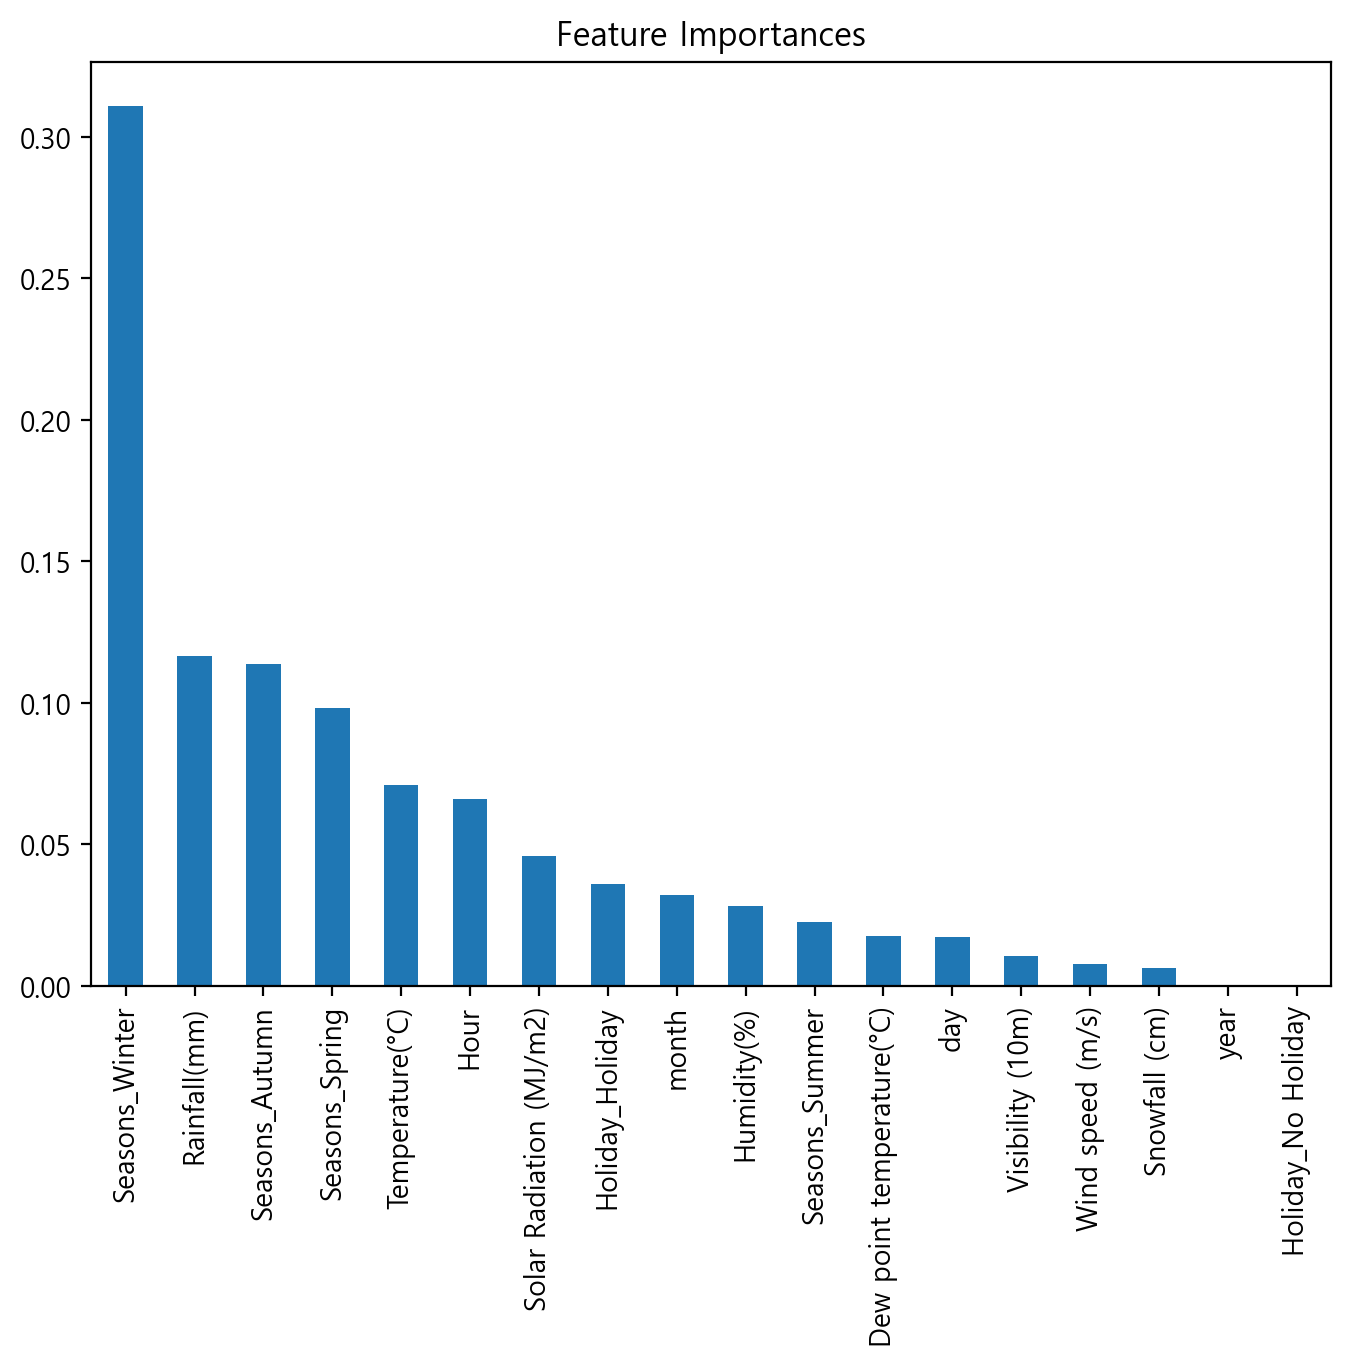

In [673]:
# 변수 중요도 계산
importances_values = pd.Series(ms_model.feature_importances_, index=X_val.columns).sort_values(ascending=False)

# 변수 중요도 시각화
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
importances_values.plot(kind='bar')
plt.title('Feature Importances')
plt.show()


- Seasons_Winter의 영향이 가장 크고 그 다음으로 온도, 강수량, 시간이 비슷한 수준으로 영향을 끼친다. 
- 사계절 중 겨울이 대여량에 가장 큰 영향을 미친다.
- 온도와 강수량이 비슷한 수준의 영향을 끼친다는 것은 기상환경에 따라 대여량의 변화한다는 것이다. 따라서 기상환경에 따른 대책 방안을 생각해보아야 한다.

## 최종모델
test 예측

In [682]:
X_test = test.copy()

In [683]:
X_train.columns

Index(['Hour', 'Temperature(°C)', 'Humidity(%)', 'Wind speed (m/s)',
       'Visibility (10m)', 'Dew point temperature(°C)',
       'Solar Radiation (MJ/m2)', 'Rainfall(mm)', 'Snowfall (cm)', 'month',
       'year', 'day', 'Seasons_Autumn', 'Seasons_Spring', 'Seasons_Summer',
       'Seasons_Winter', 'Holiday_Holiday', 'Holiday_No Holiday'],
      dtype='object')

In [684]:
X_test.columns

Index(['Hour', 'Temperature(°C)', 'Humidity(%)', 'Wind speed (m/s)',
       'Visibility (10m)', 'Dew point temperature(°C)',
       'Solar Radiation (MJ/m2)', 'Rainfall(mm)', 'Snowfall (cm)', 'month',
       'year', 'day', 'Seasons_Autumn', 'Seasons_Spring', 'Seasons_Summer',
       'Seasons_Winter', 'Holiday_Holiday', 'Holiday_No Holiday',
       'Rented Bike Count'],
      dtype='object')

In [685]:
# X_train의 칼럼 중 X_test에 없는 칼럼 찾기
missing_columns = set(X_train.columns) - set(X_test.columns)

# X_test에 누락된 칼럼 추가하고 0으로 초기화
for column in missing_columns:
    X_test[column] = 0

In [686]:
X_test = X_test[X_train.columns]

In [687]:
# 최종 모델
final_model = XGBRegressor(random_state=42, n_estimators= 300, max_depth=8, learning_rate=0.05, subsample=0.8)

# 모델 학습
final_model.fit(X_train, y_train)

# test 데이터로 예측
test['Rented Bike Count'] = final_model.predict(X_test)

In [688]:
test

,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),month,year,day,Seasons_Autumn,Seasons_Spring,Seasons_Summer,Seasons_Winter,Holiday_Holiday,Holiday_No Holiday,Rented Bike Count
0,22,27.1,79,1.200000,1578,23.1,0.00,0.0,0.0,7,2018,11,0.0,0.0,1.0,0.0,0.0,1.0,1742.067627
1,11,5.7,15,1.100000,1419,-19.0,0.98,0.0,0.0,11,2018,28,1.0,0.0,0.0,0.0,0.0,1.0,595.247681
2,15,19.0,21,3.300000,1716,-3.8,2.88,0.0,0.0,4,2018,18,0.0,1.0,0.0,0.0,0.0,1.0,1266.842041
3,14,8.0,42,1.704428,1690,-4.1,1.24,0.0,0.0,3,2018,9,0.0,1.0,0.0,0.0,0.0,1.0,646.202515
4,16,12.2,65,1.900000,2000,5.8,0.52,0.0,0.0,10,2018,28,1.0,0.0,0.0,0.0,0.0,1.0,913.780029
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1747,7,15.3,60,2.000000,2000,7.5,0.35,0.0,0.0,5,2018,8,0.0,1.0,0.0,0.0,0.0,1.0,770.753784
1748,17,8.5,59,2.700000,1927,0.9,0.16,0.0,0.0,3,2018,19,0.0,1.0,0.0,0.0,0.0,1.0,479.864532
1749,20,21.3,53,1.800000,2000,11.3,0.00,0.0,0.0,10,2018,4,1.0,0.0,0.0,0.0,0.0,1.0,892.253174
1750,12,19.2,31,0.500000,1994,1.6,2.40,0.0,0.0,10,2018,8,1.0,0.0,0.0,0.0,0.0,1.0,1472.252930


In [689]:
# 최종 csv 파일 저장하기
test.to_csv('test_final.csv', index=False)